In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from sklearn.metrics import confusion_matrix

from scepia.sc import (
    infer_motifs, 
    plot
)

%matplotlib inline

sc.settings.verbosity = 3
sc.logging.print_versions()
sc.set_figure_params(dpi=150)

/vol/mbconda/heeringen/envs/scepia_dev/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


-----
anndata     0.7.5
scanpy      1.6.0
sinfo       0.3.1
-----
Bio                 1.78
HTSeq               0.12.4
PIL                 8.0.1
adjustText          NA
anndata             0.7.5
appdirs             1.4.4
backcall            0.2.0
boltons             NA
brotli              NA
bucketcache         0.12.1
cairo               1.20.0
certifi             2020.11.08
cffi                1.14.3
chardet             3.0.4
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
diskcache           5.1.0
fbpca               NA
fluff               NA
genomepy            0.9.1
geosketch           1.1
get_version         2.1
gimmemotifs         0.15.2
h5py                3.1.0
idna                2.10
igraph              0.8.2
ipykernel           5.3.4
ipython_genutils    0.2.0
ipywidgets          7.5.1
jedi                0.17.2
jinja2              2.11.2
joblib              0.17.0
kiwisolver          1.3.1
legacy_a

# Pre-process data

This tutorial is based on the `scanpy` tutorial: https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html. It uses the 10X PBMC 3K data set, an analysis of peripheral blood mononuclear cells (PBMCs) from a healthy donor.

Preprocess your scRNA-seq data as you would normally do. This includes, for instance, normalization and batch correction.
To run `scepia` it is important to make sure of the following:

* Gene names are used in `adata.var_names`, not Ensembl identifiers or any other gene identifiers. Currently, the motifs are matched to genes by name. 
* The raw, log-transformed data is stored in `adata.raw`. Not all relevant transcription factors will be called as hypervariable genes, therefore `scepia` uses the raw data.
* The main `AnnData` object is filtered to contain the hypervariable genes.
* Louvain or Leiden clustering has been run.

The following steps are all straight from the `scanpy` tutorial. Important steps for `scepia` are marked.

In [2]:
adata = sc.datasets.pbmc3k()

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# SCEPIA: adata.raw contains raw and log-transformed data
sc.pp.log1p(adata)
adata.raw = adata

# SCEPIA: highly variable genes are called and adata is filtered
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var['highly_variable']]

sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

sc.pp.scale(adata, max_value=10)

sc.tl.pca(adata, svd_solver='arpack')

# SCEPIA: louvain clustering
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.louvain(adata)

# Here we use UMAP for visualization, you can also use t-SNE
sc.tl.umap(adata)

new_cluster_names = [
    'CD4 T', 'CD14+ Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A+ Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('louvain', new_cluster_names)

filtered out 19024 genes that are detected in less than 3 cells
normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:05)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
computing

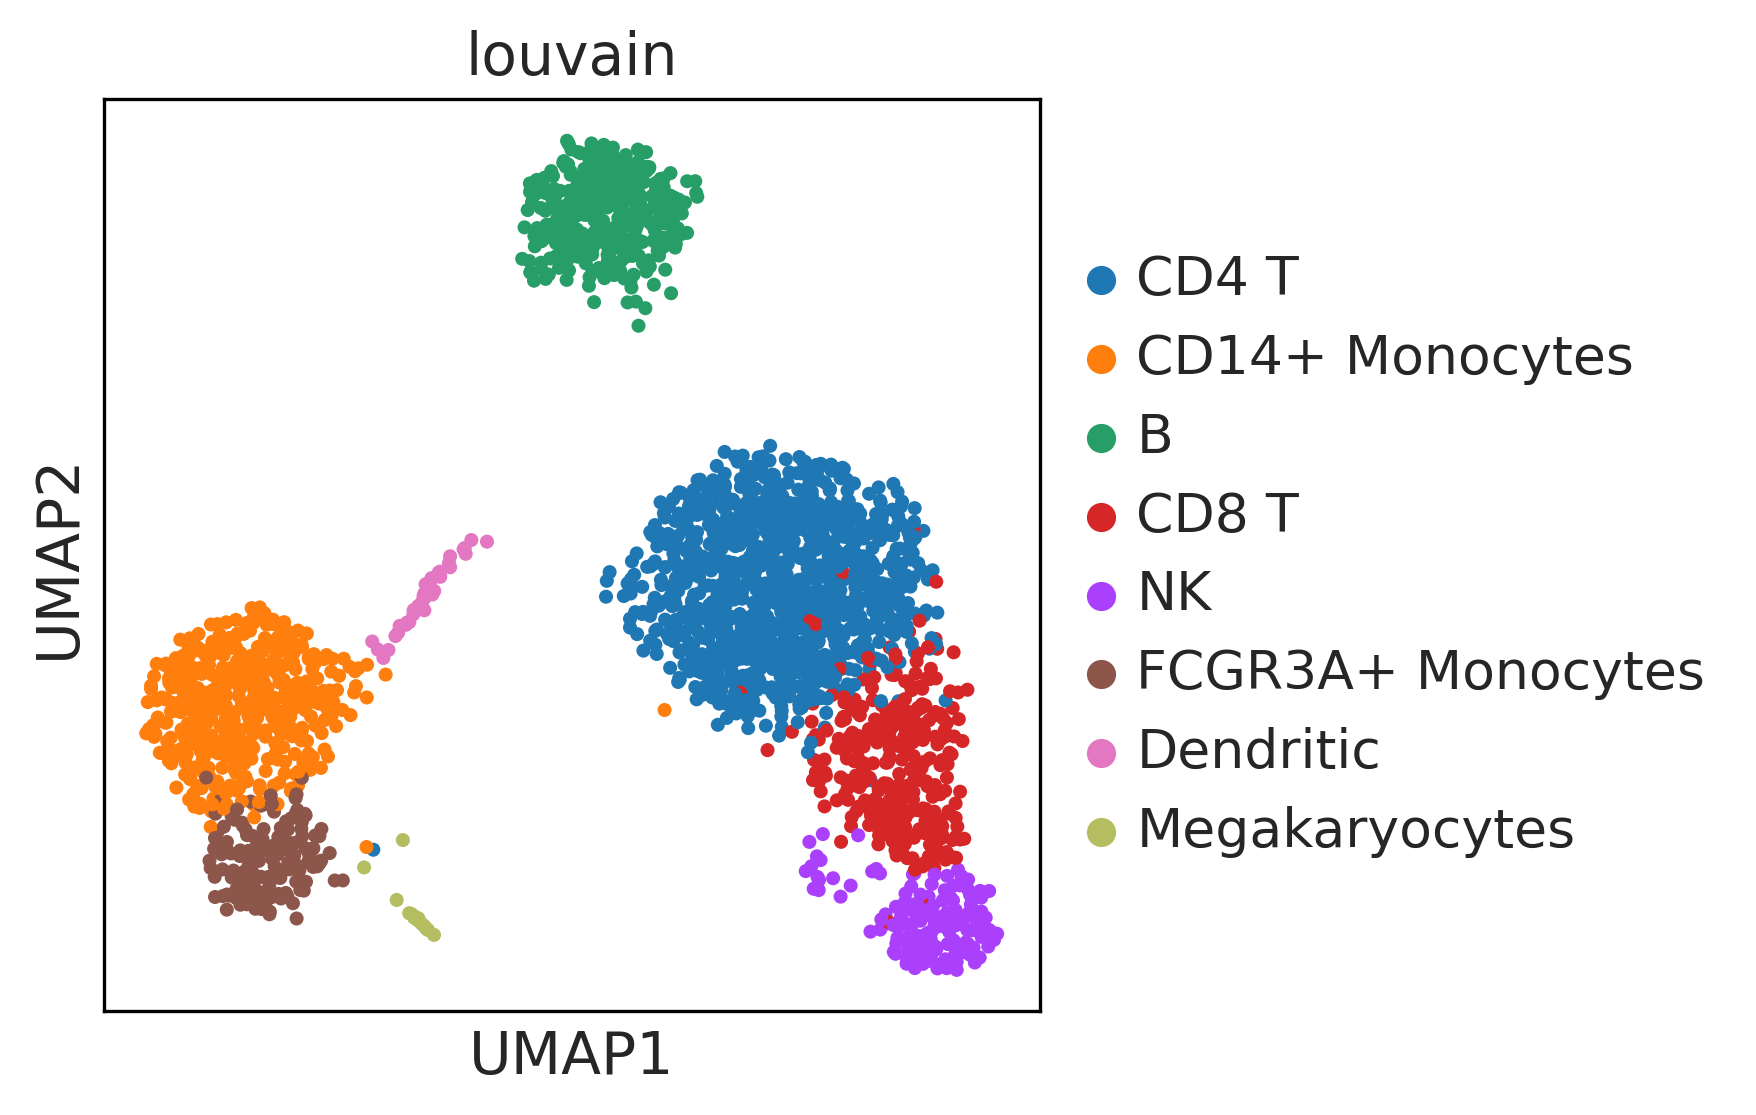

In [3]:
sc.pl.umap(adata, color=["louvain"])

# Inference of motif activity using SCEPIA

Now you can run `infer_motifs()` from the `scepia` package. The first time you run `infer_motifs()`, `scepia` will download a data package. This will take some time, but the results will be saved in `~/.cache/scepia`. 

Currently, five data packages are available:


* `ENCODE.H3K27ac.human` - All H3K27ac experiments from ENCODE. Includes cell
  lines and tissues.
* `BLUEPRINT.H3K27ac.human` - All H3K27ac cell types from BLUEPRINT (mostly
  hematopoietic cell types)
* `Domcke.ATAC.fetal.human` - Fetal single cell-based ATAC-seq clusters from
  15 different organs ([Domcke et al, 2020](http://dx.doi.org/10.1126/science.aba7612)).
* `Cusanovich.ATAC.mouse` - ATAC-seq data of single cell-based clusters from 13
  adult mouse tissues ([Cusanovich et al, 2018](http://dx.doi.org/doi:10.1016/j.cell.2018.06.052)).
* `ENCODE.H3K27ac.mouse` - All H3K27ac experiments from mouse ENCODE.

For TF motifs, the default [GimmeMotifs](https://gimmemotifs.readthedocs.org) motif database is used, but you can also use other motif databases. For instance, `pfm="JASPAR2020_vertebrates"` or `pfm="HOMER"`. Alternatively, you can also supply a file name with your own motifs in PFM format.

By default, `infer_motifs()` uses 10,000 variable enhancers for motif analysis. You can change this using the `num_enhancers` argument. In any case, only the enhancers near (<100kb) the selected hypervariable genes will be used. 

After motif inference, scepia will calculate correlations between predicted motif activity and transcription factor expression. To scale these calculations also to higher cell numbers, scepia will first create a sketch of 2,500 cells using geosketch ([Hie, 2019](https://doi.org/10.1016/j.cels.2019.05.003)). You can change this number with the `n_sketch` parameter. The sketch is based on the PCA components stored in `adata.obsm['X_pca']`. Sometimes using more components will help to create a more representative sketch.

The correlation between motif and transcription factor is usually already very informative. However, cells that are similar will receive a similar cell type assignment and therefore a similar motif activity profile. On the other hand, cells that are similar will als tend to express similar TFs. This means that motifs will sometimes be highly correlated to TF expression, even if the motif is not relevant. Therefore, we generate random permutations of the motif activity and derive an empirical p-value. The number of permutations, 100,000 by default, is controlled with the `n_permutations` parameter.

All in all, most of the steps are not directly impacted by cell numbers.

In [4]:
infer_motifs(adata, dataset="ENCODE.H3K27ac.human", n_top_genes=2000)

# Use the following command to infer motif activity for JASPAR motifs:
# infer_motifs(adata, dataset="ENCODE.H3K27ac.human", pfm="JASPAR2020_vertebrates")

2020-11-27 07:35:03 - INFO - Loading reference data (gene).
2020-11-27 07:35:04 - INFO - Selecting reference cell types
2020-11-27 07:35:04 - INFO - Using 1626 hypervariable common genes
2020-11-27 07:35:06 - INFO - 50 out of 121 selected
2020-11-27 07:35:06 - INFO - Top 5:
2020-11-27 07:35:06 - INFO -  * T-helper 17 cell
2020-11-27 07:35:06 - INFO -  * CD8-positive, alpha-beta T cell
2020-11-27 07:35:06 - INFO -  * CD14-positive monocyte
2020-11-27 07:35:06 - INFO -  * B cell
2020-11-27 07:35:06 - INFO -  * natural killer cell
2020-11-27 07:35:06 - INFO - Annotating cells.


2020-11-27 07:35:53 - INFO - Linking variable genes to differential enhancers.


2020-11-27 07:36:07 - INFO - Loading reference data (enhancer).
2020-11-27 07:36:30 - INFO - inferring motif activity
2020-11-27 07:36:30 - INFO - Activity based on genome hg38
2020-11-27 07:36:37,867 - INFO - motif scanning (scores)
2020-11-27 07:36:37,869 - INFO - reading table
2020-11-27 07:36:48,141 - INFO - creating score table (z-score, GC%)
2020-11-27 07:39:36,603 - INFO - done
2020-11-27 07:39:38,901 - INFO - creating dataframe
2020-11-27 07:39:43,480 - INFO - Fitting BayesianRidge


2020-11-27 07:46:10,119 - INFO - Done
2020-11-27 07:46:10 - INFO - calculating cell-specific motif activity


2020-11-27 07:46:10 - INFO - correlating motif activity with factors
2020-11-27 07:46:10 - INFO - including indirect and/or predicted factors
2020-11-27 07:46:13 - INFO - creating sketch of 2500 cells
2020-11-27 07:46:14 - INFO - calculating correlation of motif activity with 463 factors
2020-11-27 07:46:19 - INFO - calculating 100000 permutations


2020-11-27 07:51:57 - INFO - calculating permutation-based p-values (all)


2020-11-27 07:54:10 - INFO - calculating permutation-based p-values (factor-specific)


2020-11-27 07:54:14 - INFO - Inferring factor activity.


2020-11-27 07:54:27 - INFO - Done with motif inference.


# Cell type annotation

The cell types of all single cells are annotated based on matching H3K27ac profiles. You can check this using the `cell_annotation` and the `cluster_annotation` properties that are stored in `adata.obs`. The `cluster_annotation` is just the majority vote of all cell types in the cluster.

... storing 'cluster_annotation' as categorical
... storing 'cell_annotation' as categorical


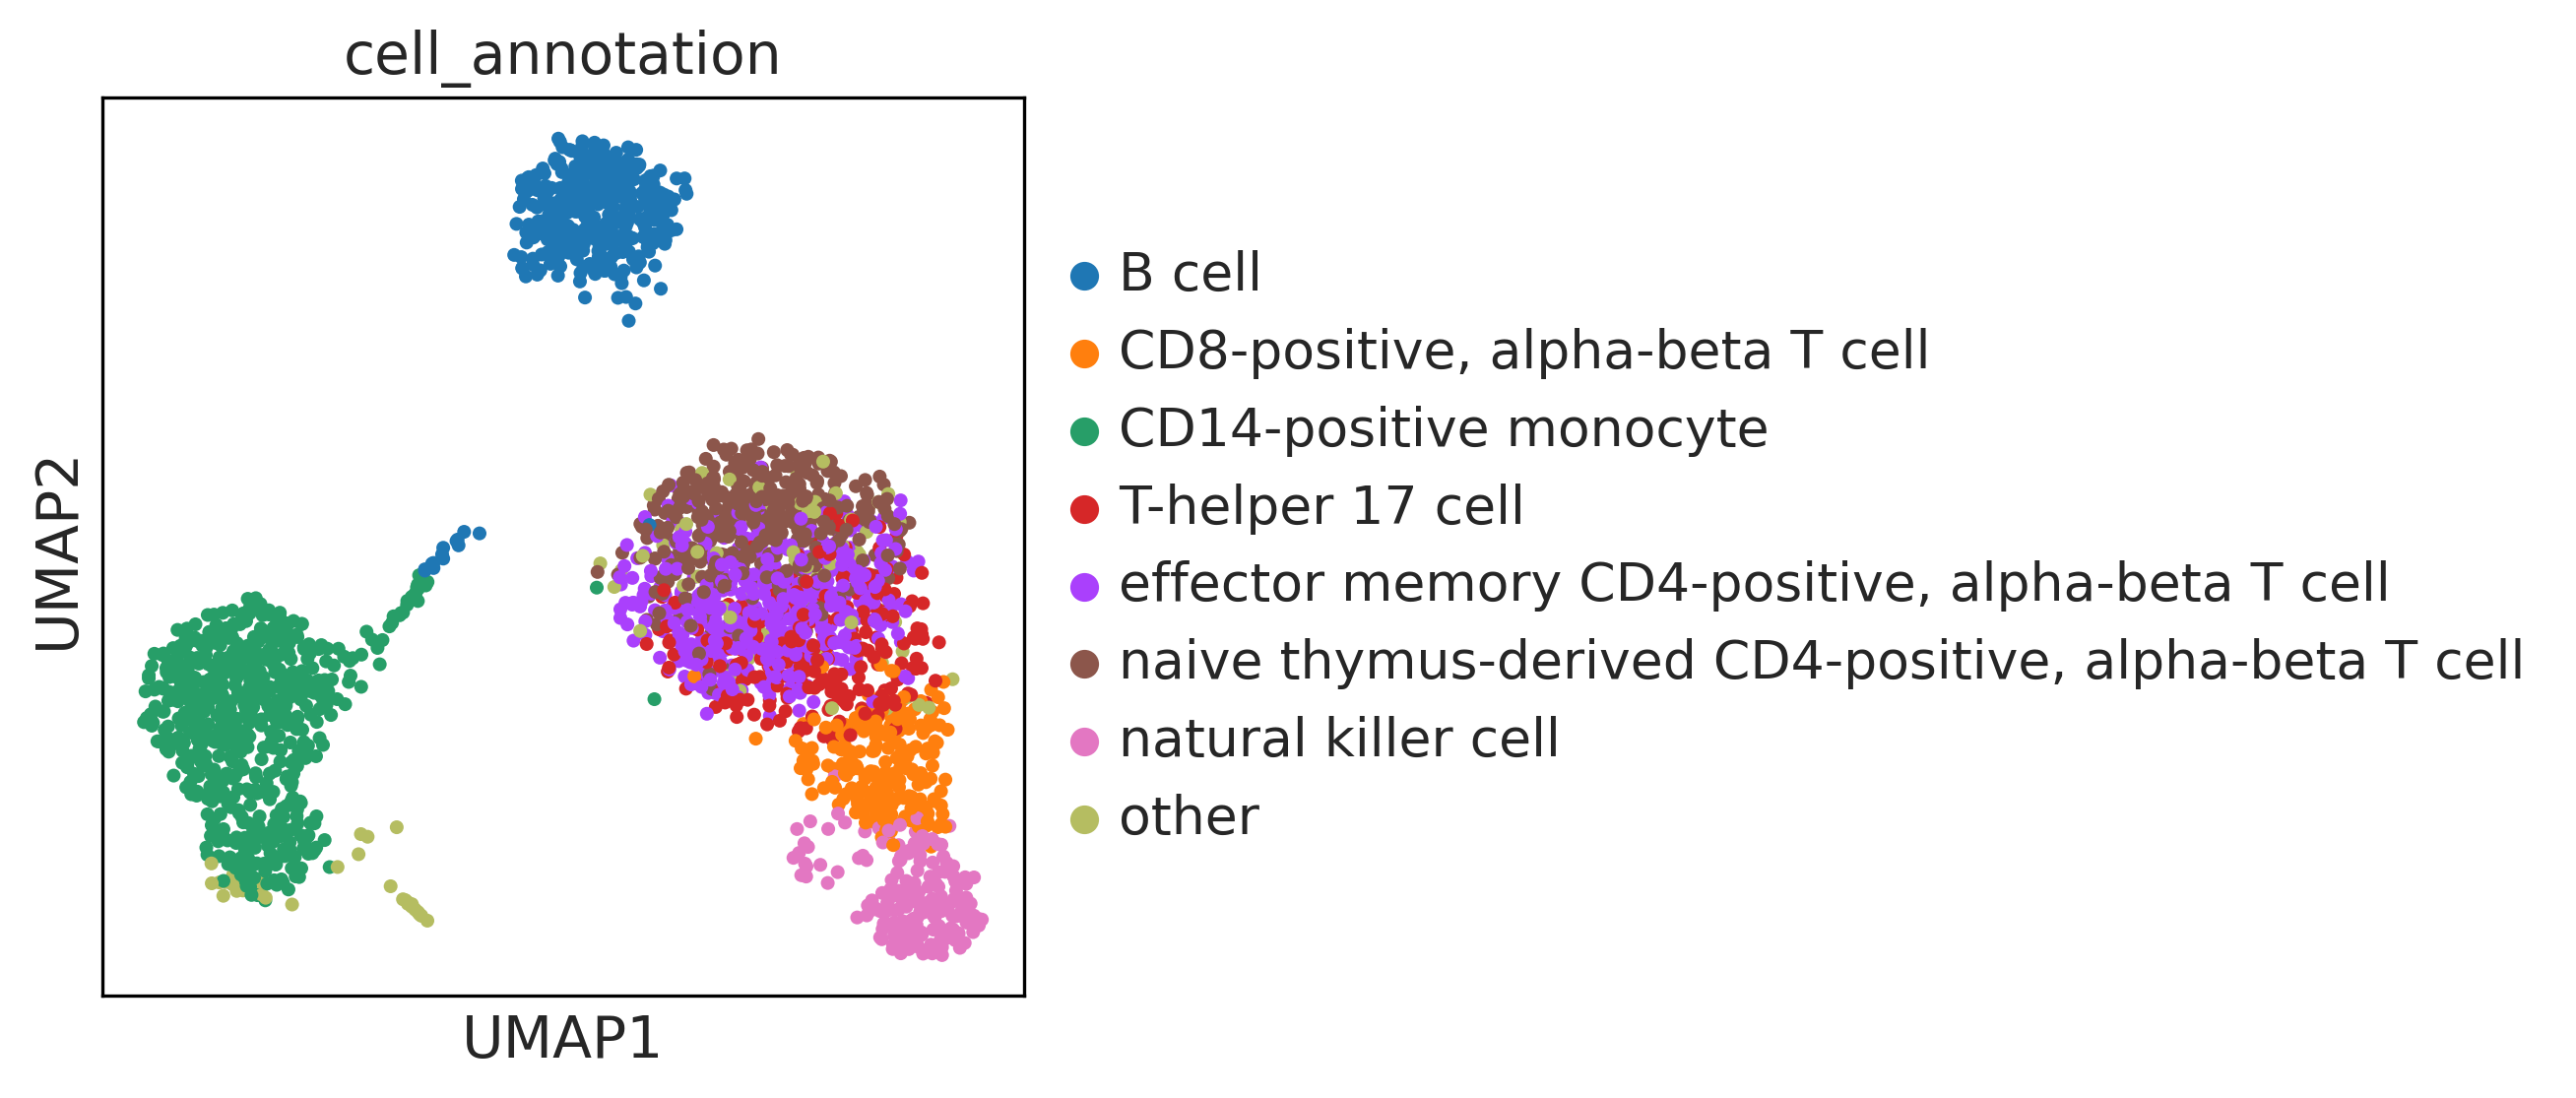

In [5]:
sc.pl.umap(adata, color="cell_annotation")

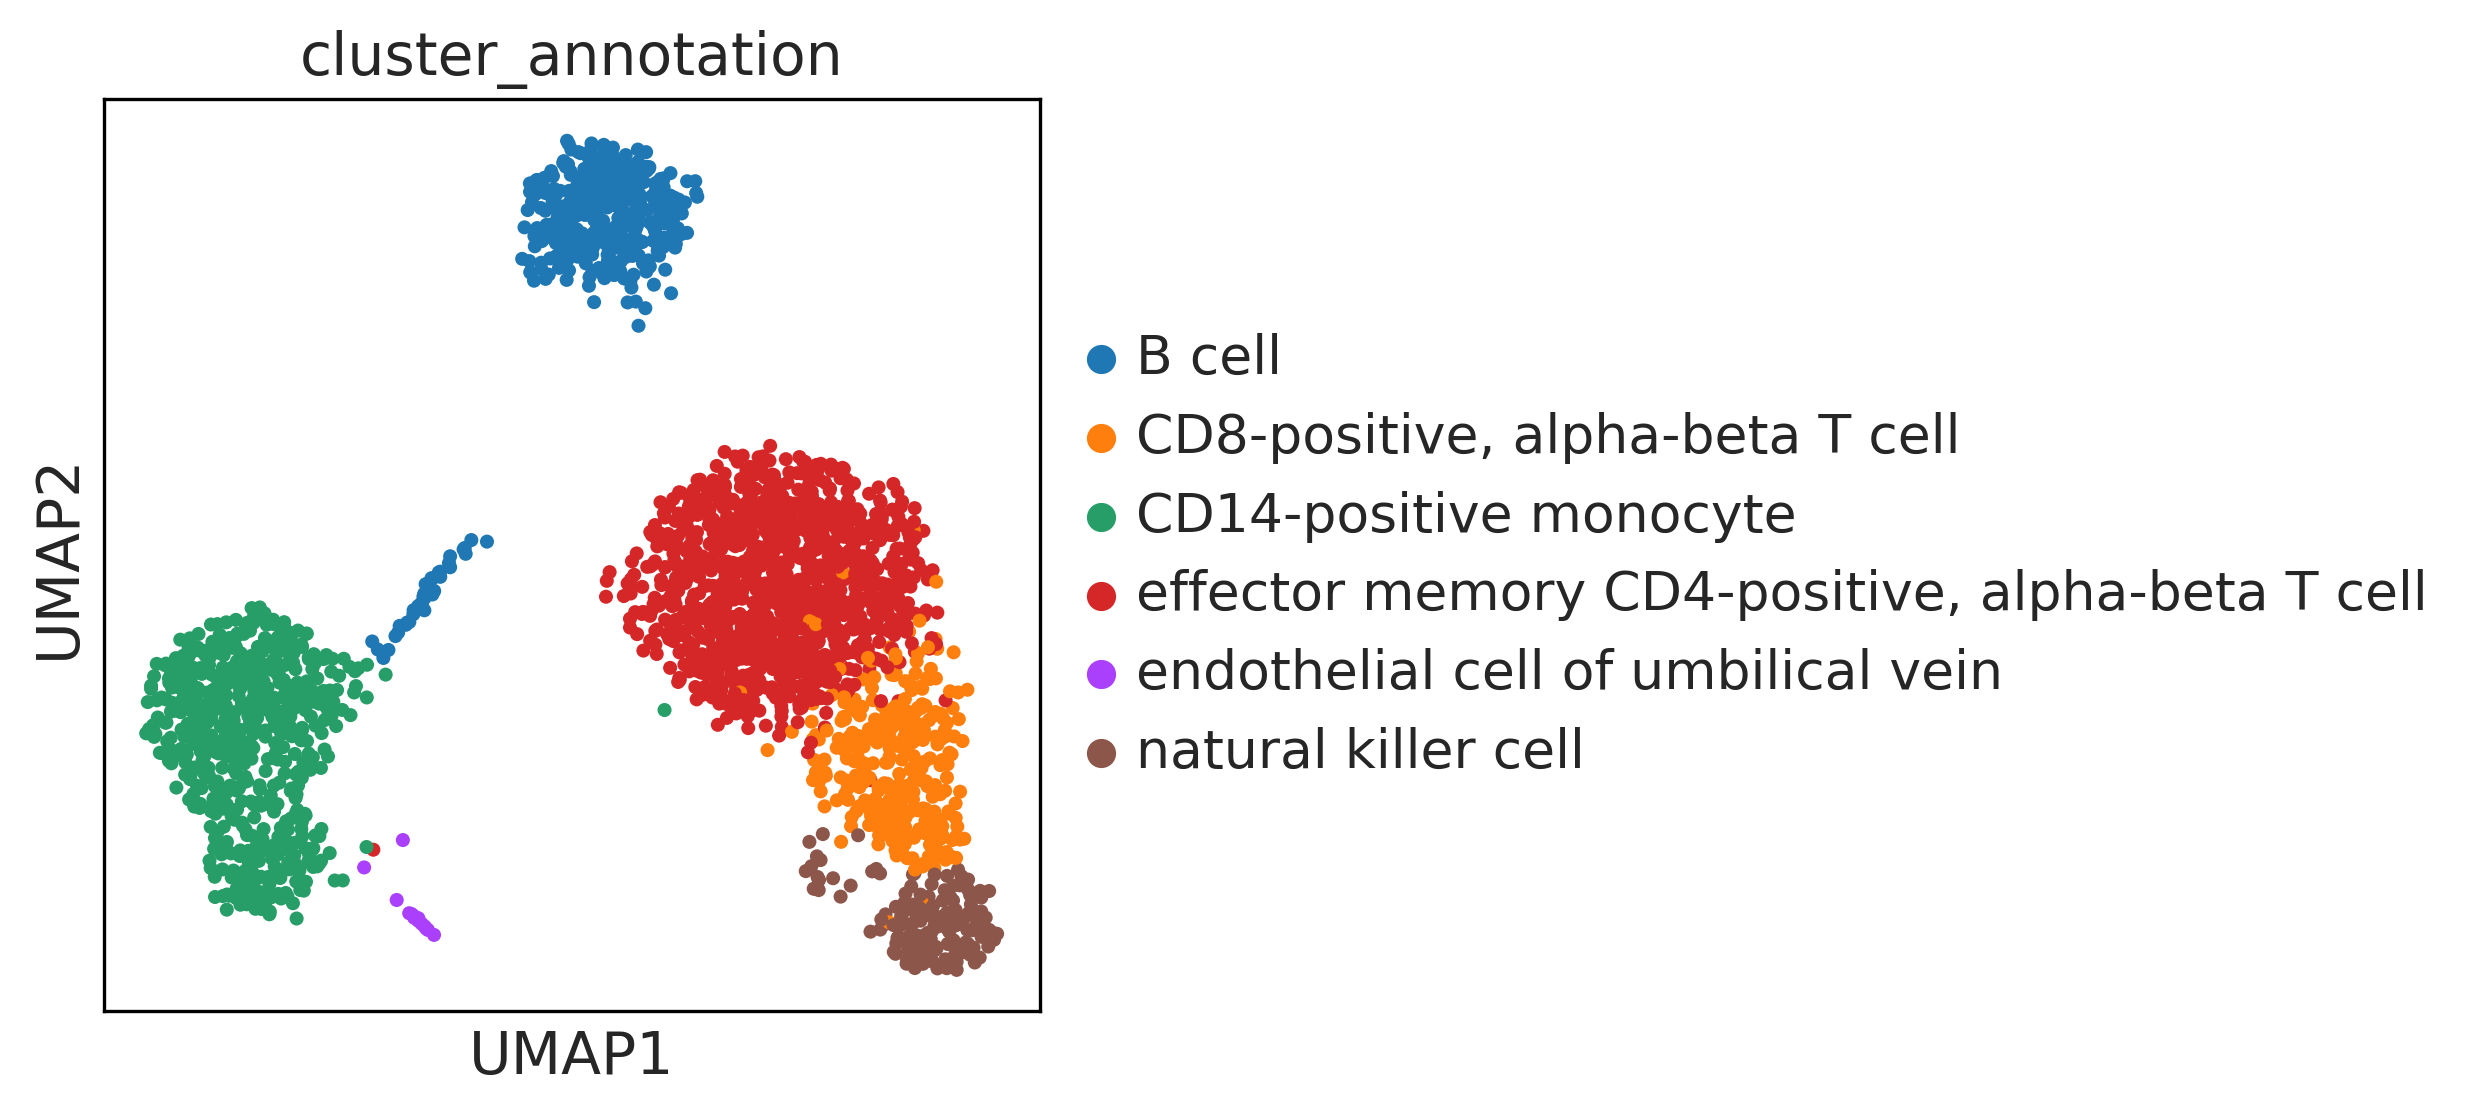

In [6]:
sc.pl.umap(adata, color="cluster_annotation")

The `scepia` cell type annotation only shows the most important cell type per single cell. However, the inferred H3K27ac profiles are a combination of multiple different cell types. Additionally, the cell types do not need to match perfectly to result in relevant motifs.

We can also create a confusion matrix to look at the cell type assignments.

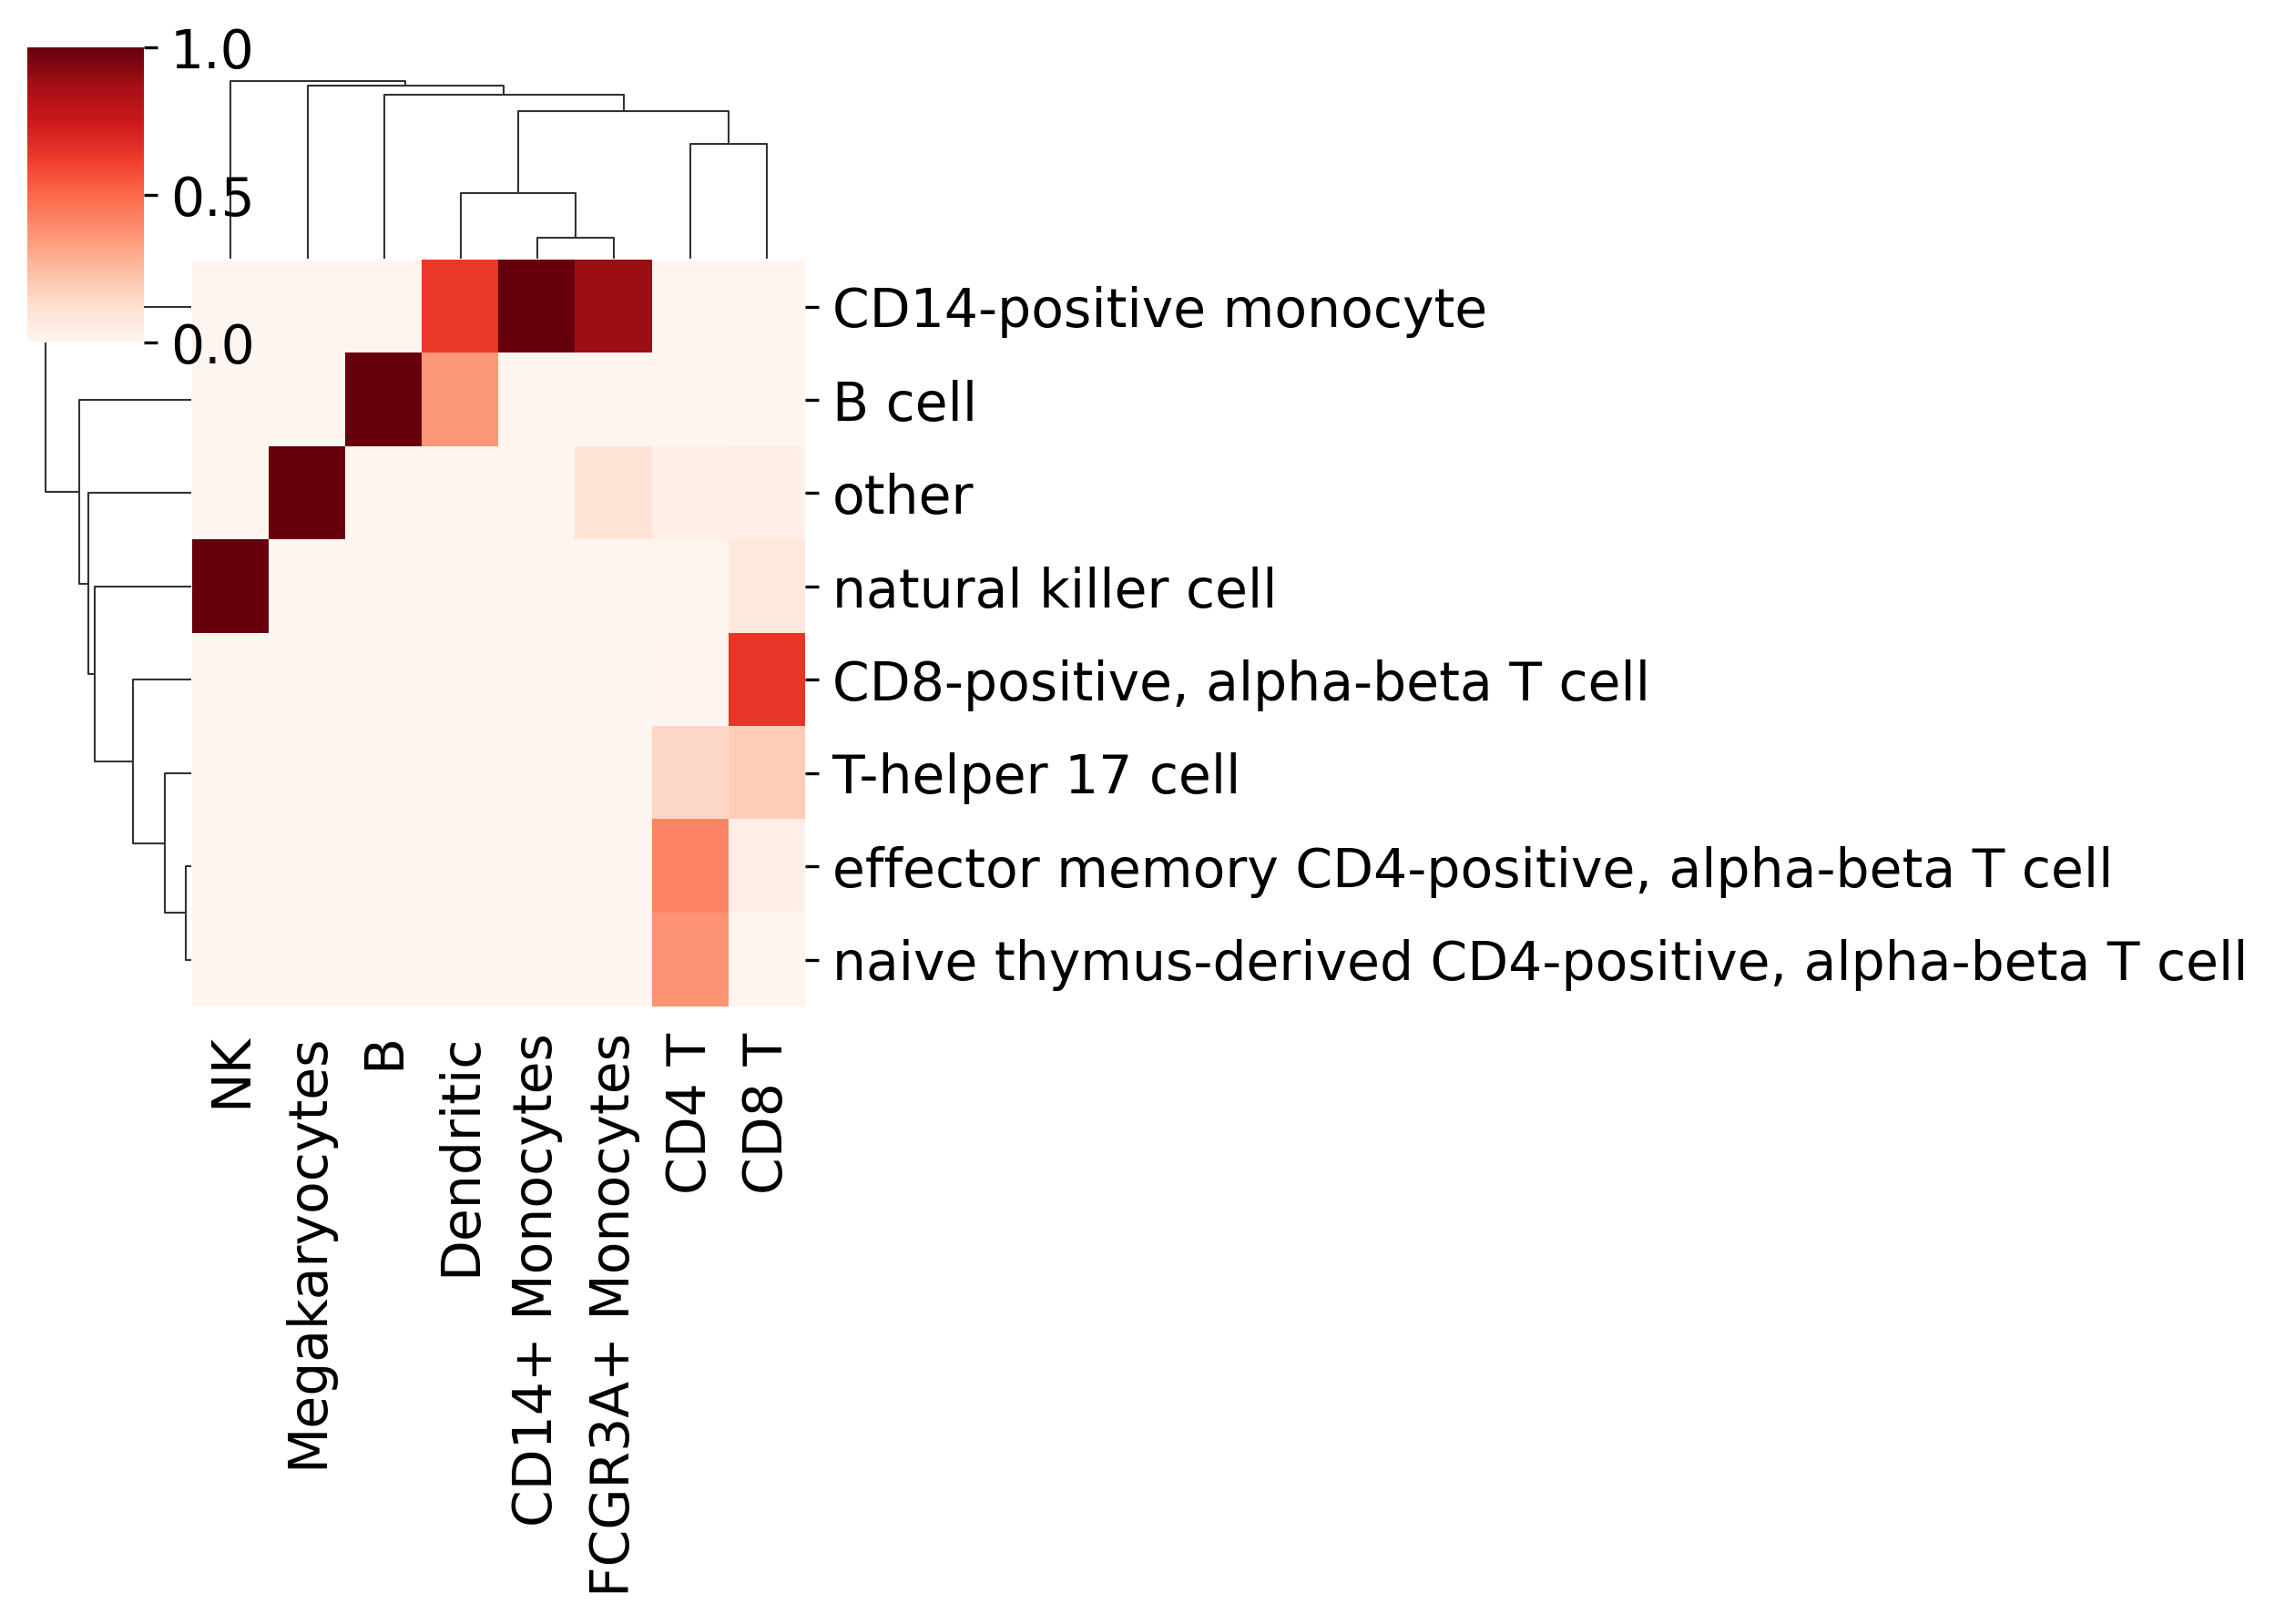

In [7]:
labels = list(set(np.hstack((adata.obs["louvain"].astype(str).unique(), adata.obs["cell_annotation"].astype(str).unique()))))

cnf_matrix = pd.DataFrame(confusion_matrix(adata.obs["louvain"], adata.obs["cell_annotation"], labels=labels), index=labels, columns=labels)
cnf_matrix = cnf_matrix.loc[adata.obs["louvain"].astype(str).unique(), adata.obs["cell_annotation"].astype(str).unique()]
cnf_matrix = cnf_matrix.div(cnf_matrix.sum(1), axis=0)
cm = sns.clustermap(cnf_matrix.T, cmap="Reds", figsize=(8.5,6))

# Motif activity

Most of the results from `infer_motifs()` are stored in `adata.uns['scepia']`. 

In [8]:
adata.uns["scepia"].keys()

dict_keys(['version', 'cell_types', 'pfm', 'motif_activity', 'correlation'])

The value of `adata.uns["scepia"]["correlation"]` is a pandas DataFrame with results of the correlation between inferred motif activity and expression of the transcription factor. This can be used to prioritize relevant motifs.

In [9]:
adata.uns["scepia"]["correlation"].sort_values("p_adj").head(20)

motif  correlation  abs_correlation          pval  \
factor                                                                 
SPI1     GM.5.0.Ets.0015     0.621040         0.621040  3.621012e-07   
CEBPD   GM.5.0.bZIP.0061     0.581973         0.581973  1.120384e-05   
SPI1     GM.5.0.Ets.0010     0.609311         0.609311  1.214104e-06   
SPI1     GM.5.0.Ets.0014     0.605983         0.605983  1.597505e-06   
CEBPD   GM.5.0.bZIP.0052     0.581213         0.581213  1.169374e-05   
SPI1     GM.5.0.Ets.0008     0.595071         0.595071  4.877716e-06   
CEBPD   GM.5.0.bZIP.0039     0.562118         0.562118  2.811609e-05   
CEBPB   GM.5.0.bZIP.0011     0.484038         0.484038  1.993687e-04   
CEBPB   GM.5.0.bZIP.0042     0.481729         0.481729  2.062912e-04   
CEBPB   GM.5.0.bZIP.0052     0.478853         0.478853  2.155567e-04   
SPI1     GM.5.0.Ets.0001     0.572002         0.572002  1.853106e-05   
NFE2    GM.5.0.bZIP.0005     0.288031         0.288031  2.739274e-03   
CEBPB   GM.5.0.bZIP.0039     0.469745         0.469745  2.442479e-04   
SPI1     GM.5.0.Ets.0043     0.561053         0.561053  2.935150e-05   
CEBPA   GM.5.0.bZIP.0046     0.237819         0.237819  5.264398e-03   
MAFB    GM.5.0.bZIP.0091    -0.429400         0.429400  4.238927e-04   
ETS1     GM.5.0.Ets.0044    -0.206181         0.206181  8.041565e-03   
CEBPA   GM.5.0.bZIP.0011     0.237098         0.237098  5.317733e-03   
MAFB    GM.5.0.bZIP.0023    -0.420593         0.420593  4.818502e-04   
CEBPA   GM.5.0.bZIP.0069     0.234928         0.234928  5.478740e-03   

        permutation_pval      combined     p_adj  -log10(p-value)  \
factor                                                              
SPI1            0.000168  1.488844e-09  0.000003         5.466557   
CEBPD           0.000099  2.389213e-08  0.000013         4.902925   
SPI1            0.000562  1.508651e-08  0.000013         4.902925   
SPI1            0.000740  2.547077e-08  0.000013         4.902925   
CEBPD           0.000108  2.725533e-08  0.000013         4.902925   
SPI1            0.002258  2.128677e-07  0.000081         4.089448   
CEBPD           0.001410  7.154273e-07  0.000234         3.629939   
CEBPB           0.000306  1.073541e-06  0.000308         3.511678   
CEBPB           0.000375  1.343268e-06  0.000342         3.465486   
CEBPB           0.000552  2.017073e-06  0.000463         3.334685   
SPI1            0.008047  2.493155e-06  0.000520         3.284050   
NFE2            0.000118  5.167984e-06  0.000919         3.036712   
CEBPB           0.001341  5.219014e-06  0.000919         3.036712   
SPI1            0.012051  5.608193e-06  0.000919         3.036712   
CEBPA           0.000227  1.747930e-05  0.002673         2.572974   
MAFB            0.003215  1.976888e-05  0.002834         2.547544   
ETS1            0.000187  2.170627e-05  0.002929         2.533270   
CEBPA           0.000325  2.469085e-05  0.003147         2.502143   
MAFB            0.006144  4.064786e-05  0.004908         2.309122   
CEBPA           0.000582  4.353351e-05  0.004993         2.301613   

        motif_stddev  
factor                
SPI1        0.042126  
CEBPD       0.011315  
SPI1        0.027014  
SPI1        0.020263  
CEBPD       0.018050  
SPI1        0.012823  
CEBPD       0.016135  
CEBPB       0.020299  
CEBPB       0.020065  
CEBPB       0.018050  
SPI1        0.011669  
NFE2        0.009893  
CEBPB       0.016135  
SPI1        0.008186  
CEBPA       0.017680  
MAFB        0.009949  
ETS1        0.009691  
CEBPA       0.020299  
MAFB        0.001824  
CEBPA       0.016286

You can visualize the inferred TF activity with the normal scanpy plotting functions, using `{FACTOR_NAME}_activity`. For instance, to plot the activity of two of the top factor, CEBPD and SPI1 (also known as PU.1):

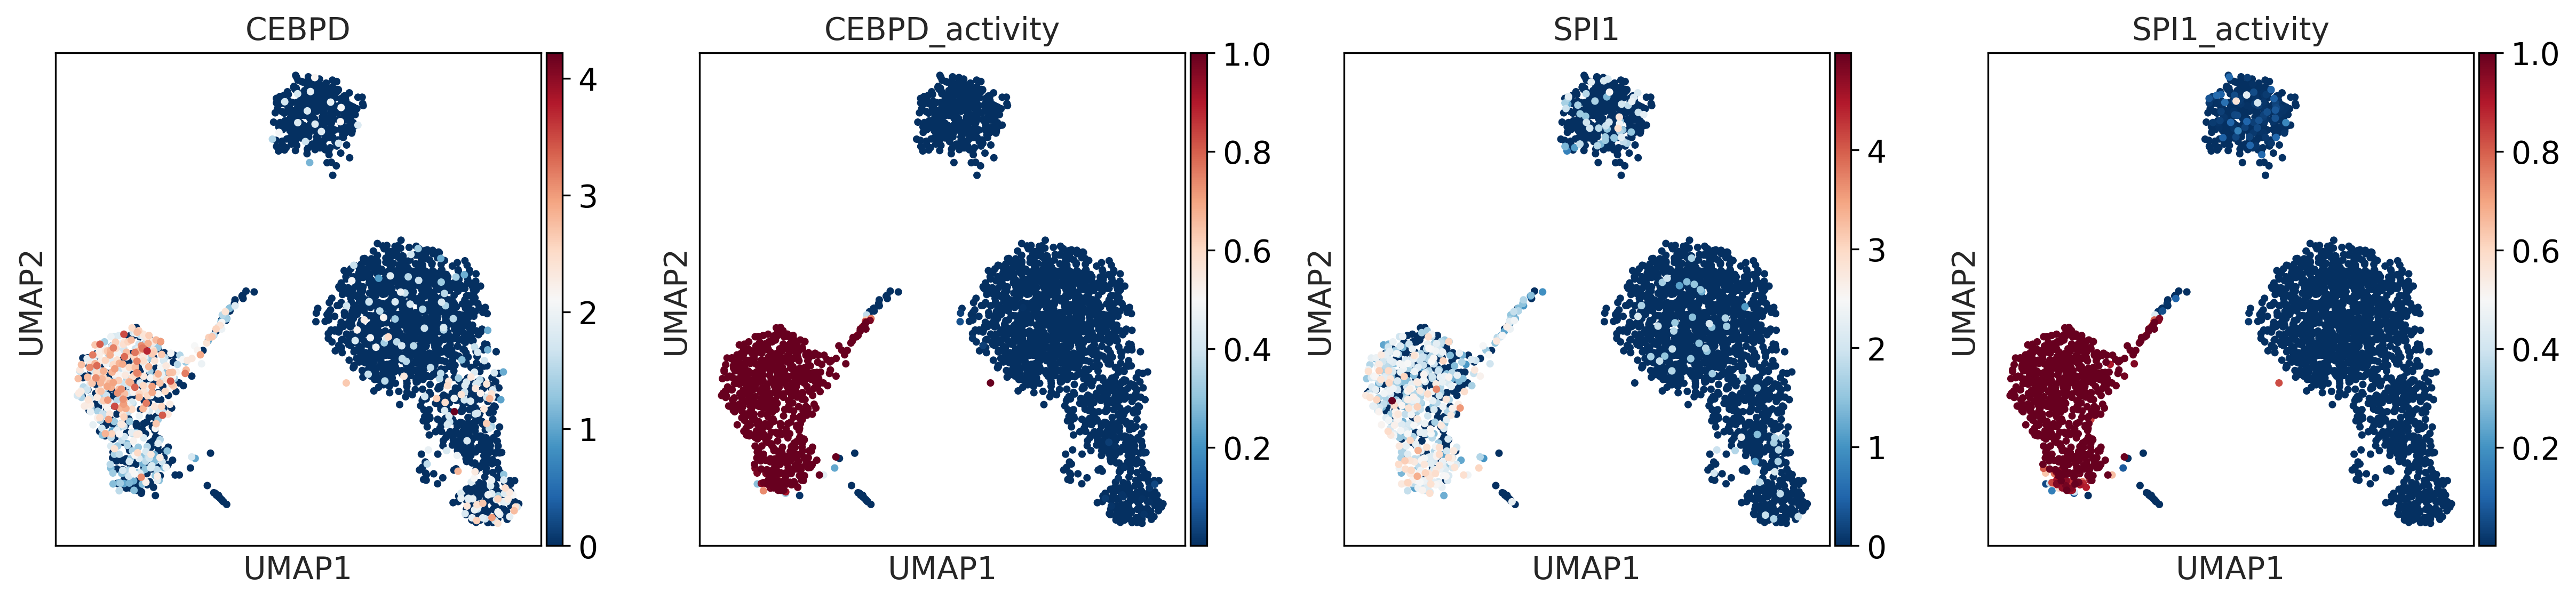

In [10]:
sc.pl.umap(adata, color=["CEBPD", "CEBPD_activity", "SPI1", "SPI1_activity"], cmap="RdBu_r")

**Please note:** this TF activity is based on the motif for that factor with the highest correlation. However, sometimes this assumption is incorrect. You can always check other motifs. 

In [11]:
f2m = adata.uns["scepia"]['correlation']
f2m.loc["CEBPD"].sort_values("p_adj").head(5)

motif  correlation  abs_correlation      pval  \
factor                                                             
CEBPD   GM.5.0.bZIP.0052     0.581213         0.581213  0.000012   
CEBPD   GM.5.0.bZIP.0061     0.581973         0.581973  0.000011   
CEBPD   GM.5.0.bZIP.0039     0.562118         0.562118  0.000028   

        permutation_pval      combined     p_adj  -log10(p-value)  \
factor                                                              
CEBPD           0.000108  2.725533e-08  0.000013         4.902925   
CEBPD           0.000099  2.389213e-08  0.000013         4.902925   
CEBPD           0.001410  7.154273e-07  0.000234         3.629939   

        motif_stddev  
factor                
CEBPD       0.018050  
CEBPD       0.011315  
CEBPD       0.016135

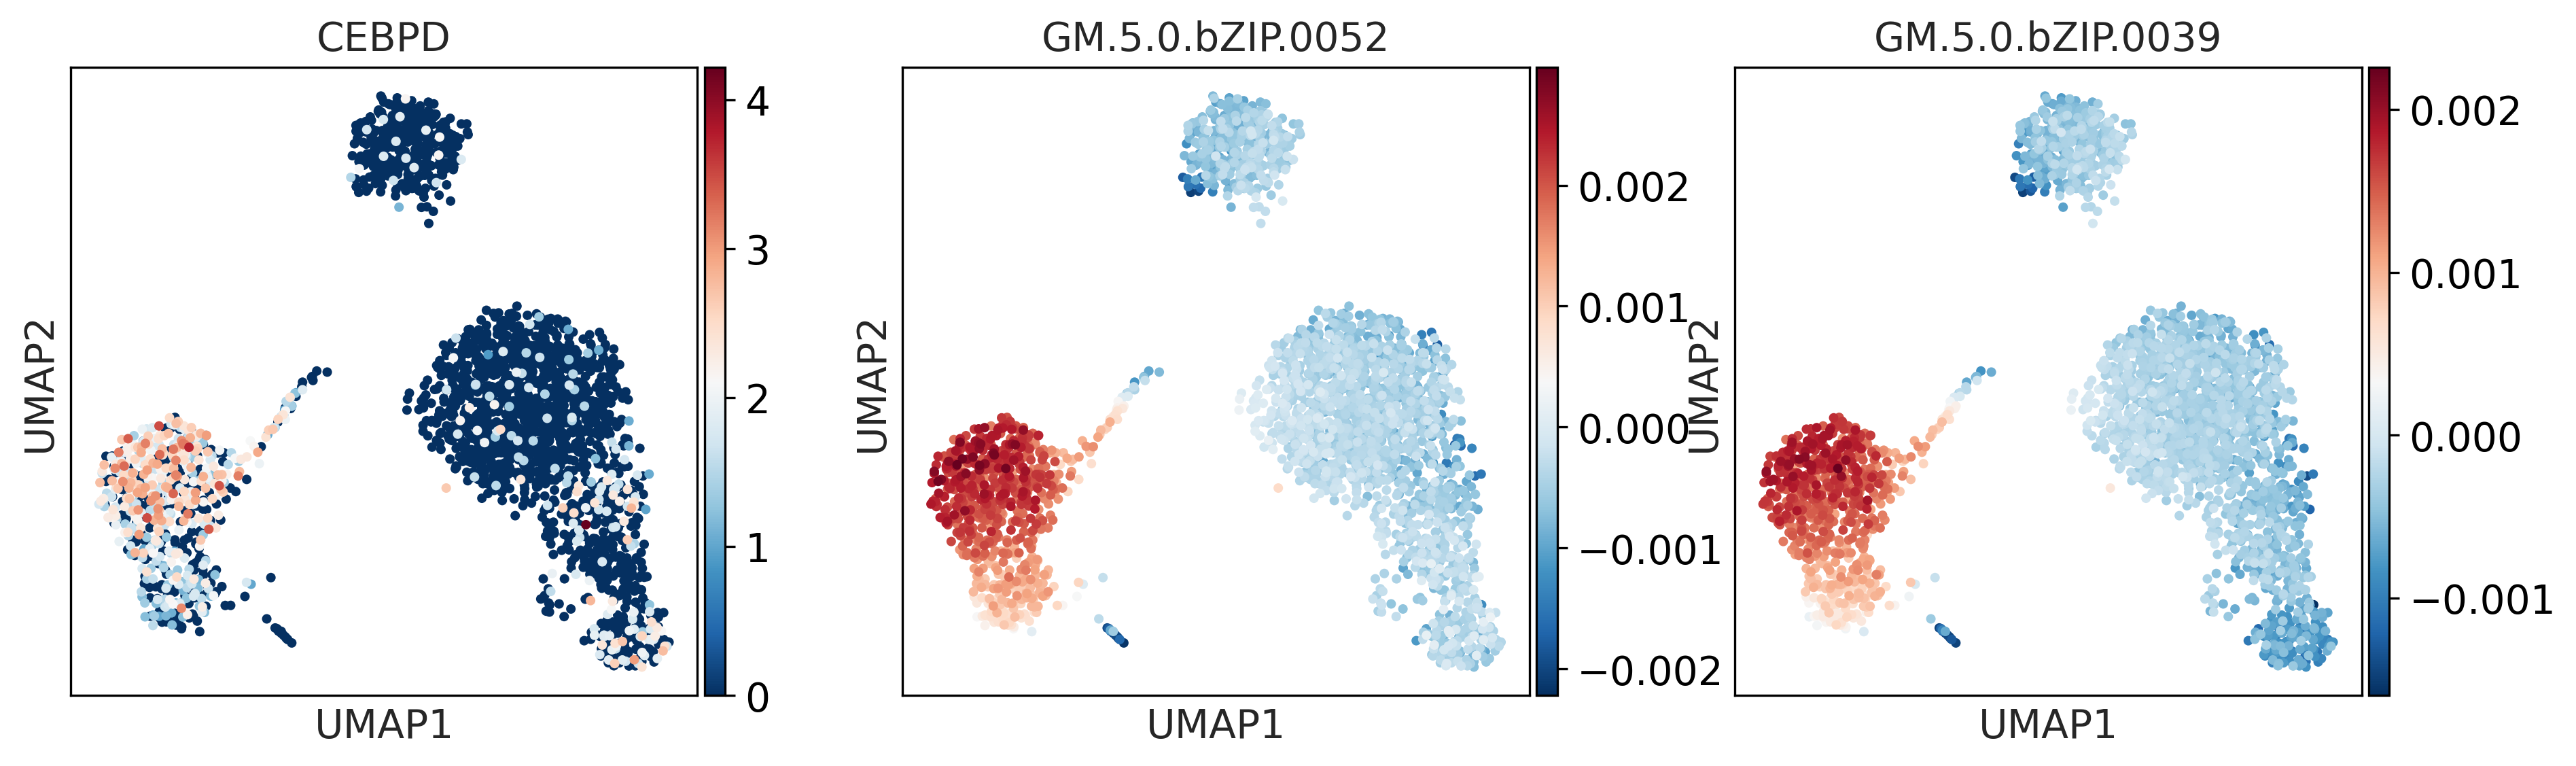

In [12]:
sc.pl.umap(adata, color=["CEBPD", "GM.5.0.bZIP.0052", "GM.5.0.bZIP.0039"], cmap="RdBu_r")

You can plot the correlated between TF and motif activity and the significance (-log10 of the p-value) in a volcano plot.

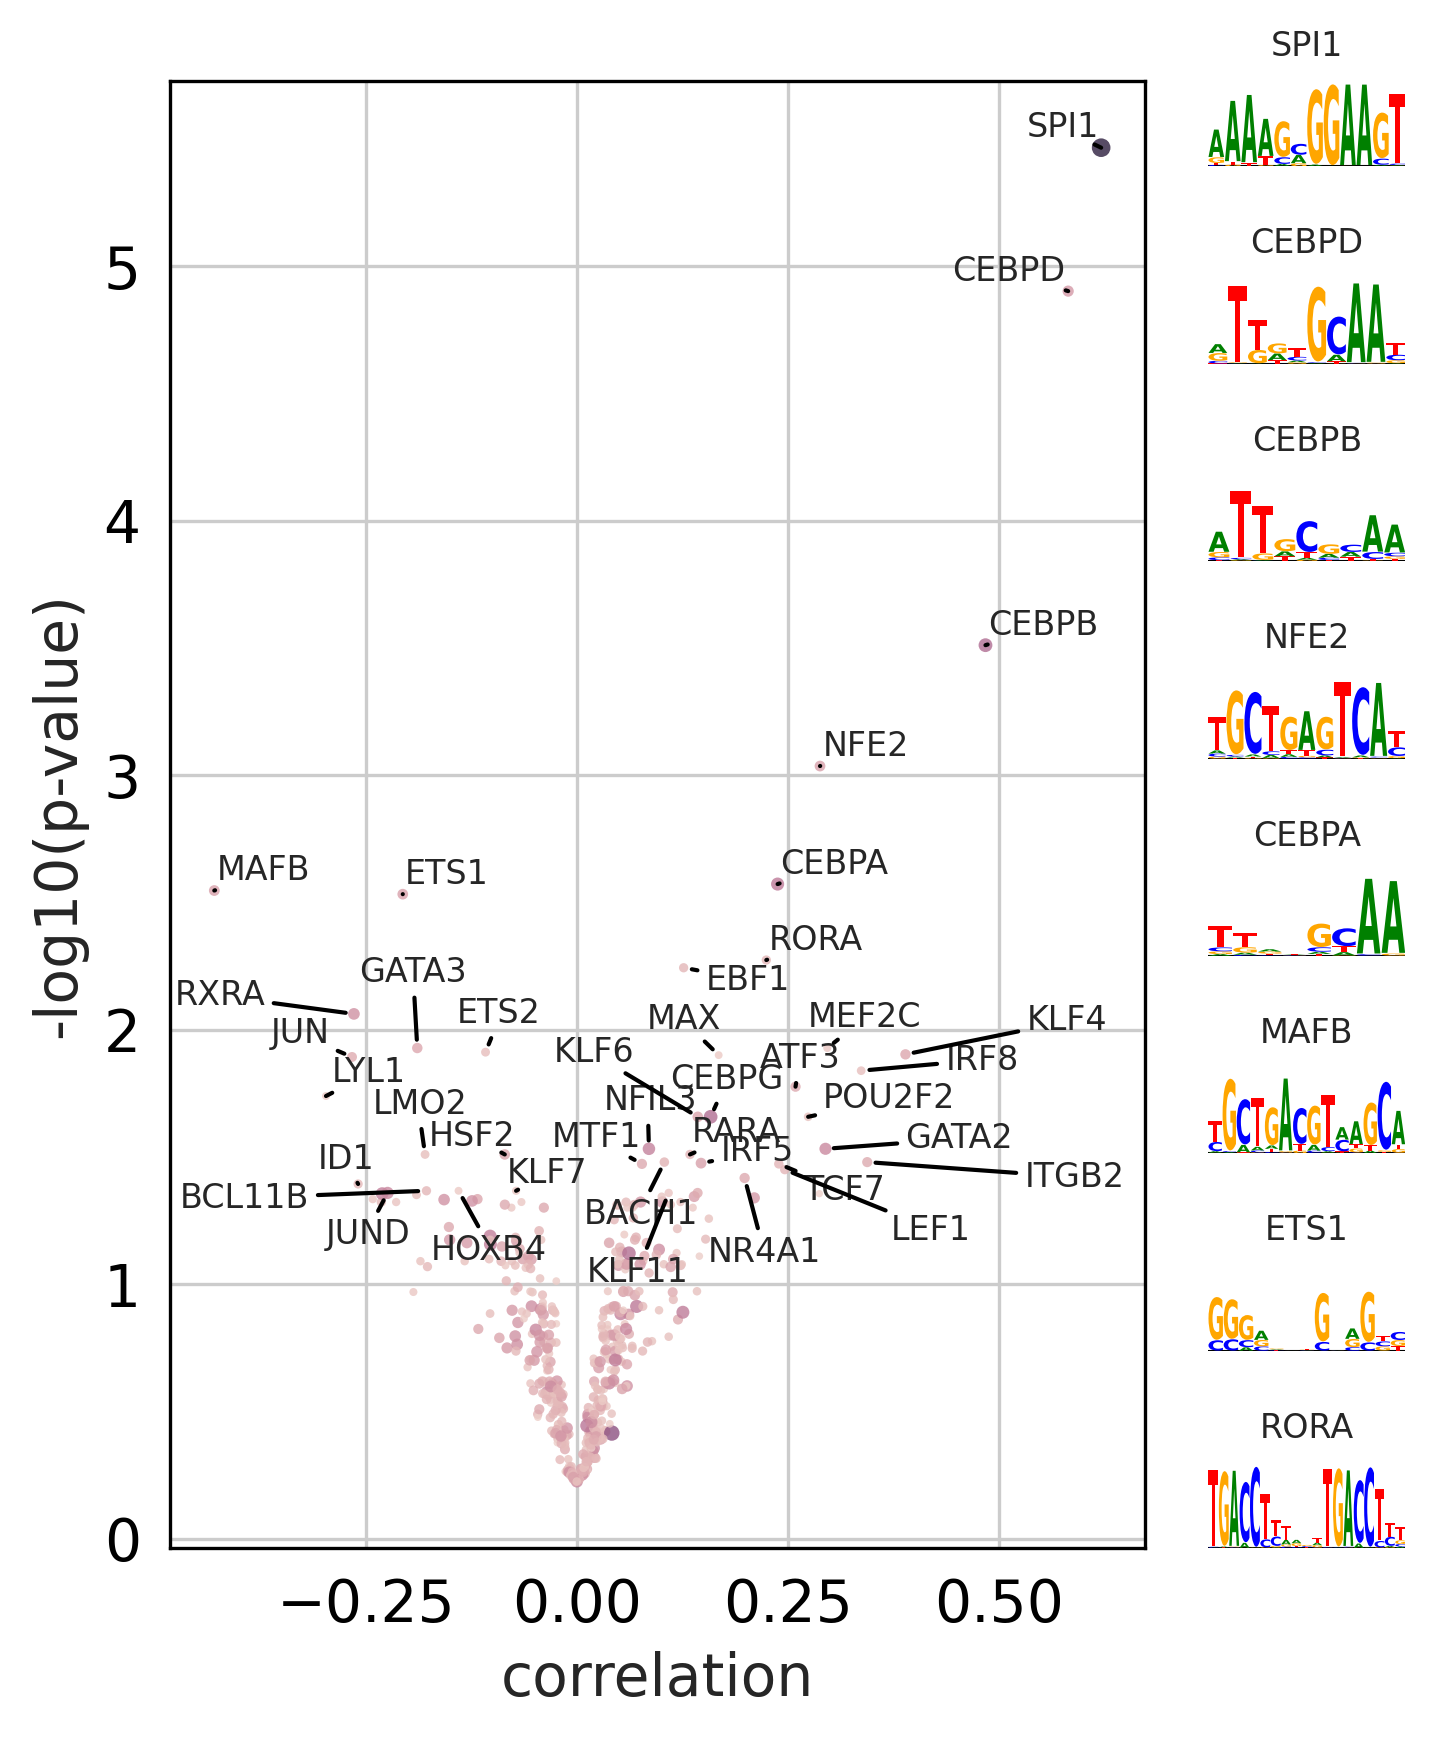

In [13]:
ax = plot(adata, n_anno=40)

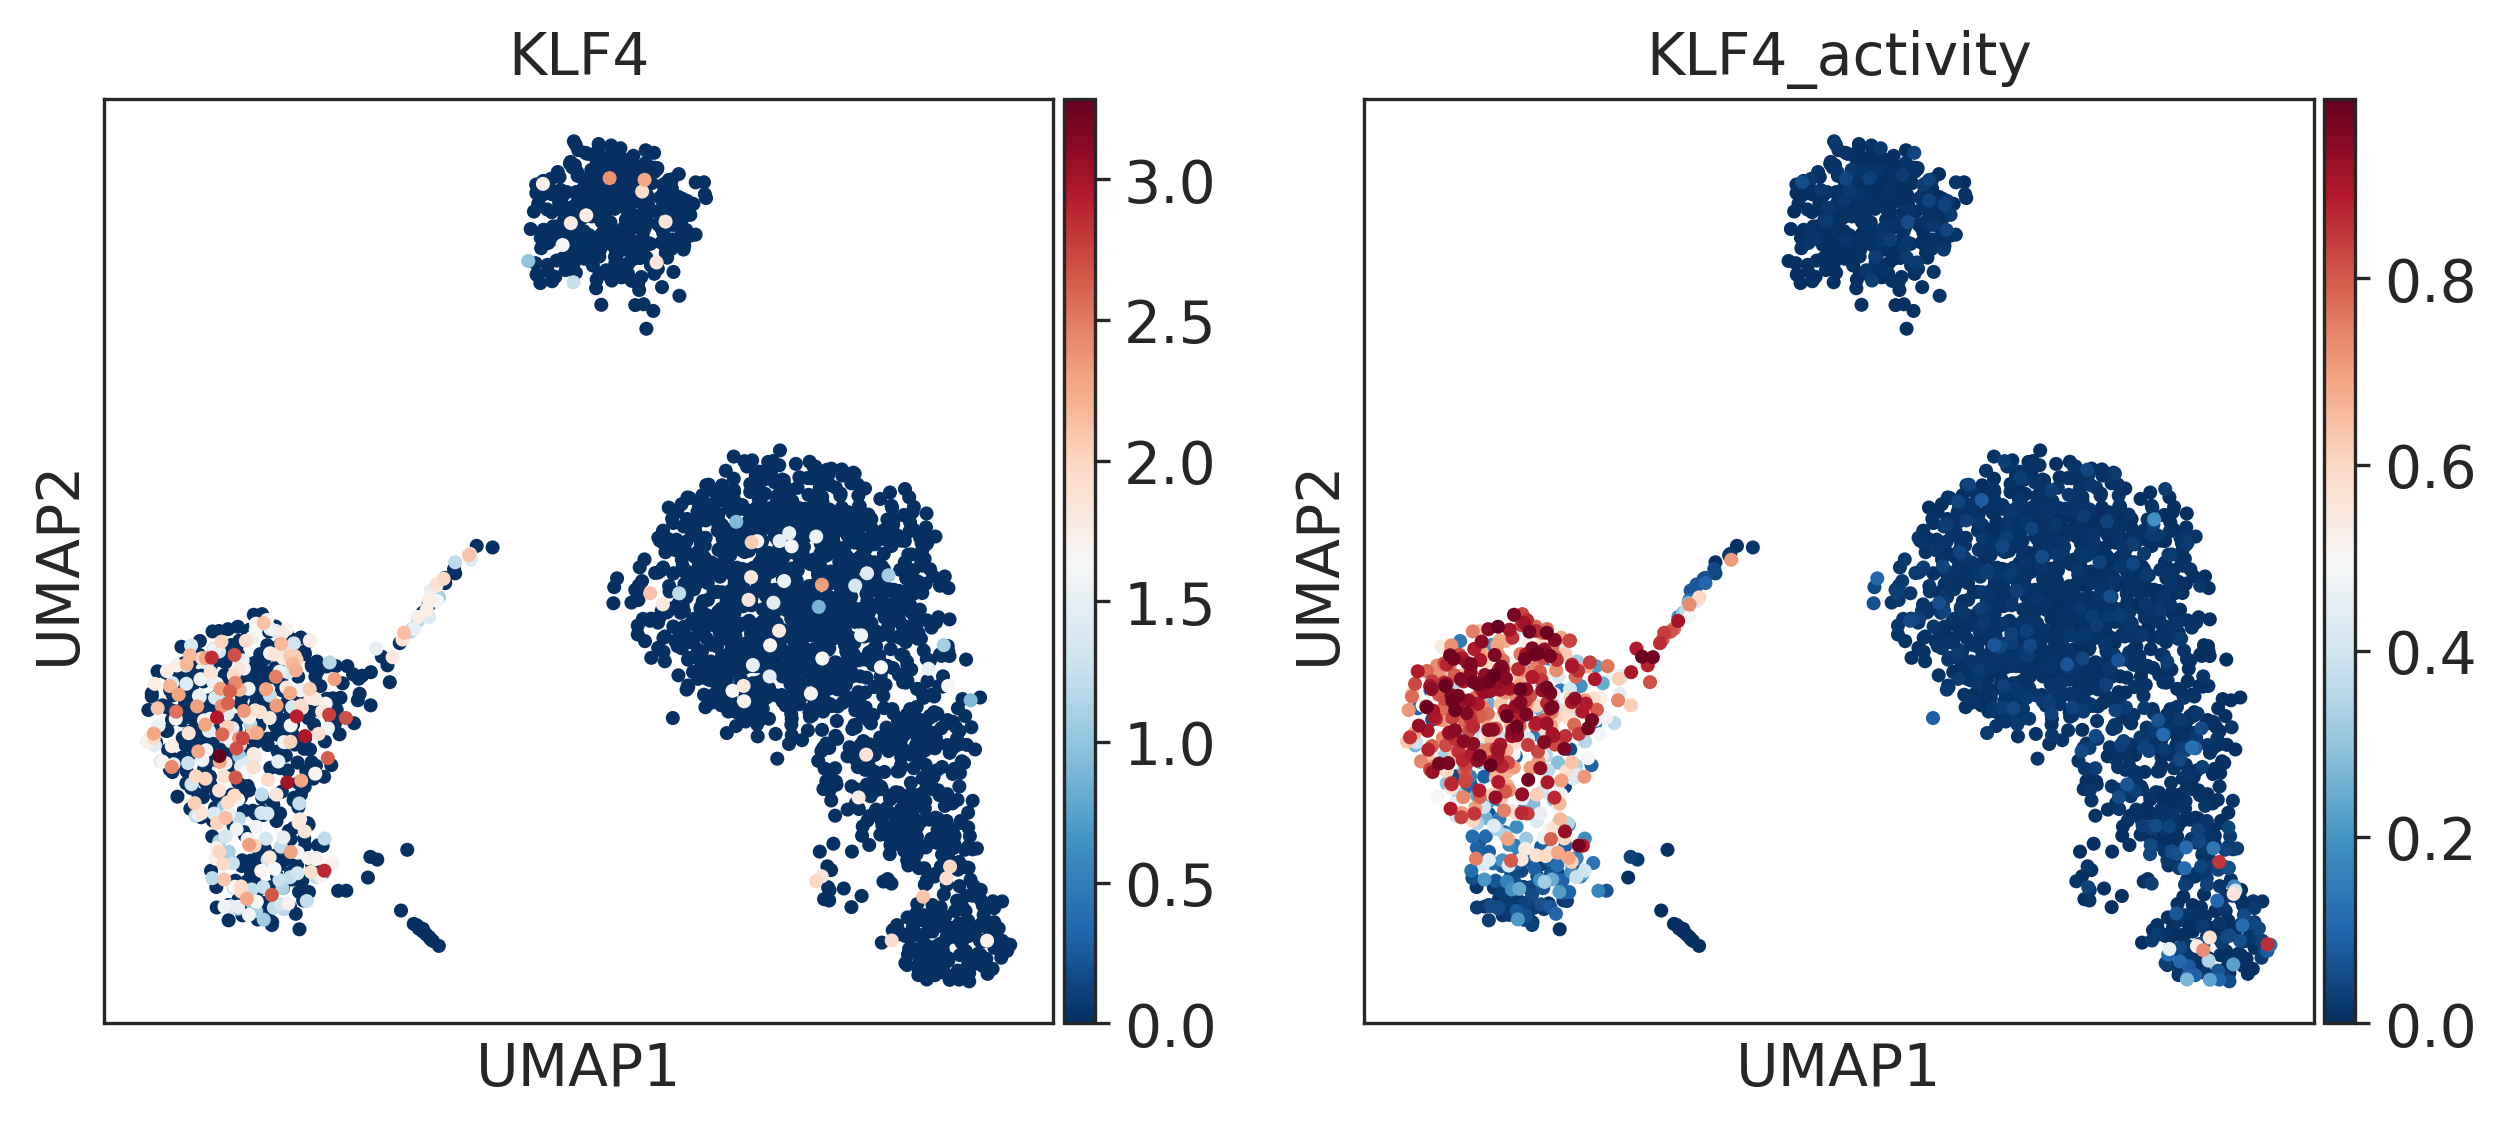

In [21]:
sc.pl.umap(adata, color=["KLF4", "KLF4_activity"], cmap="RdBu_r")

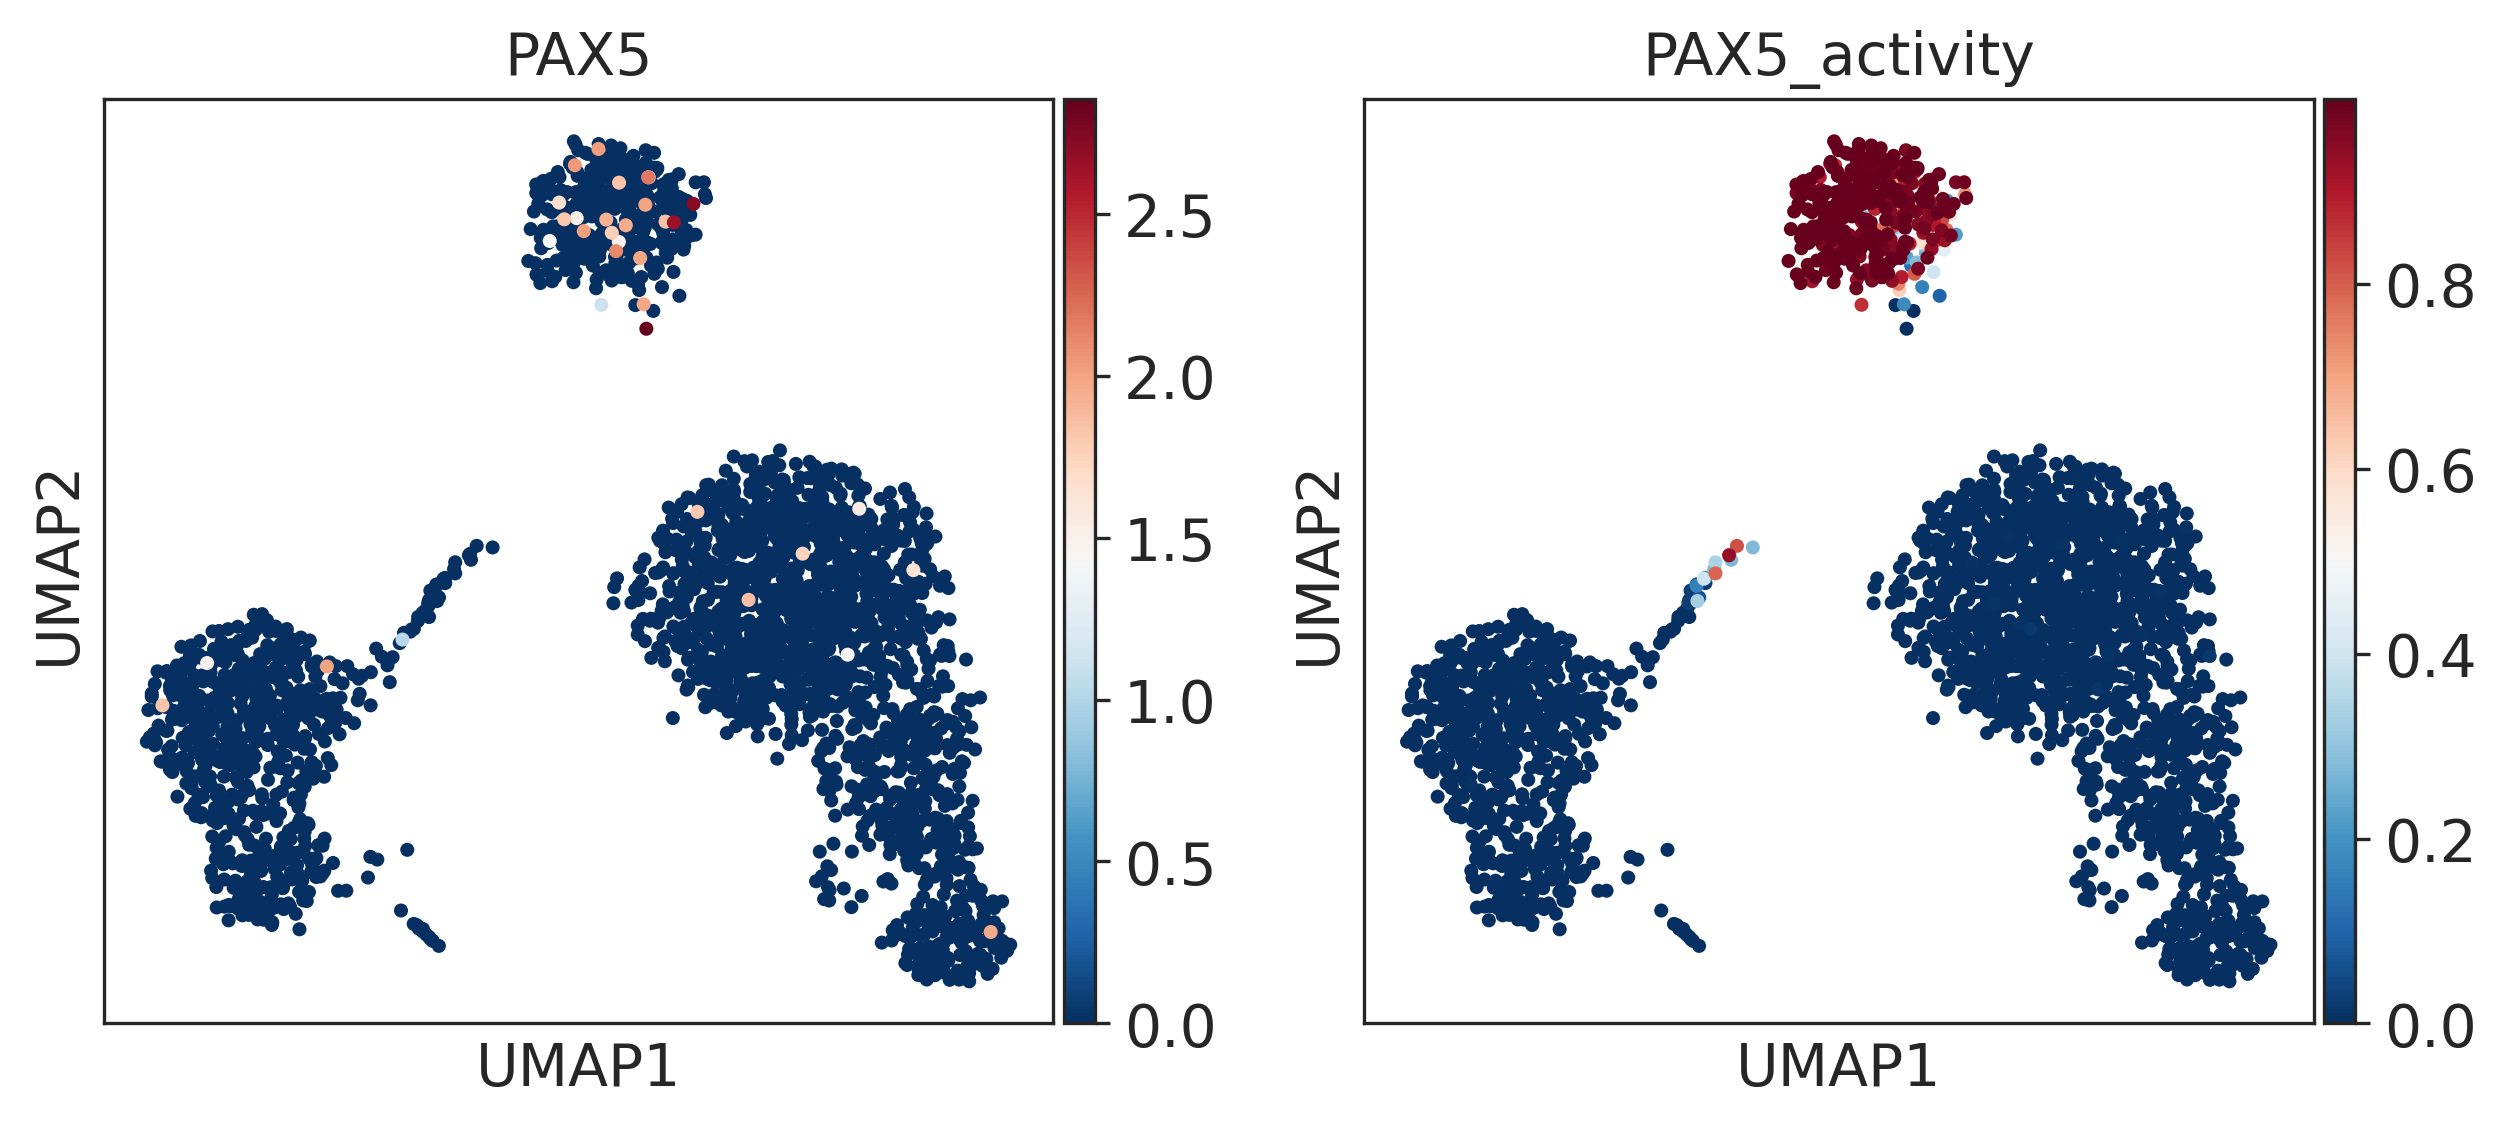

In [15]:
sc.pl.umap(adata, color=["PAX5", "PAX5_activity"], cmap="RdBu_r")

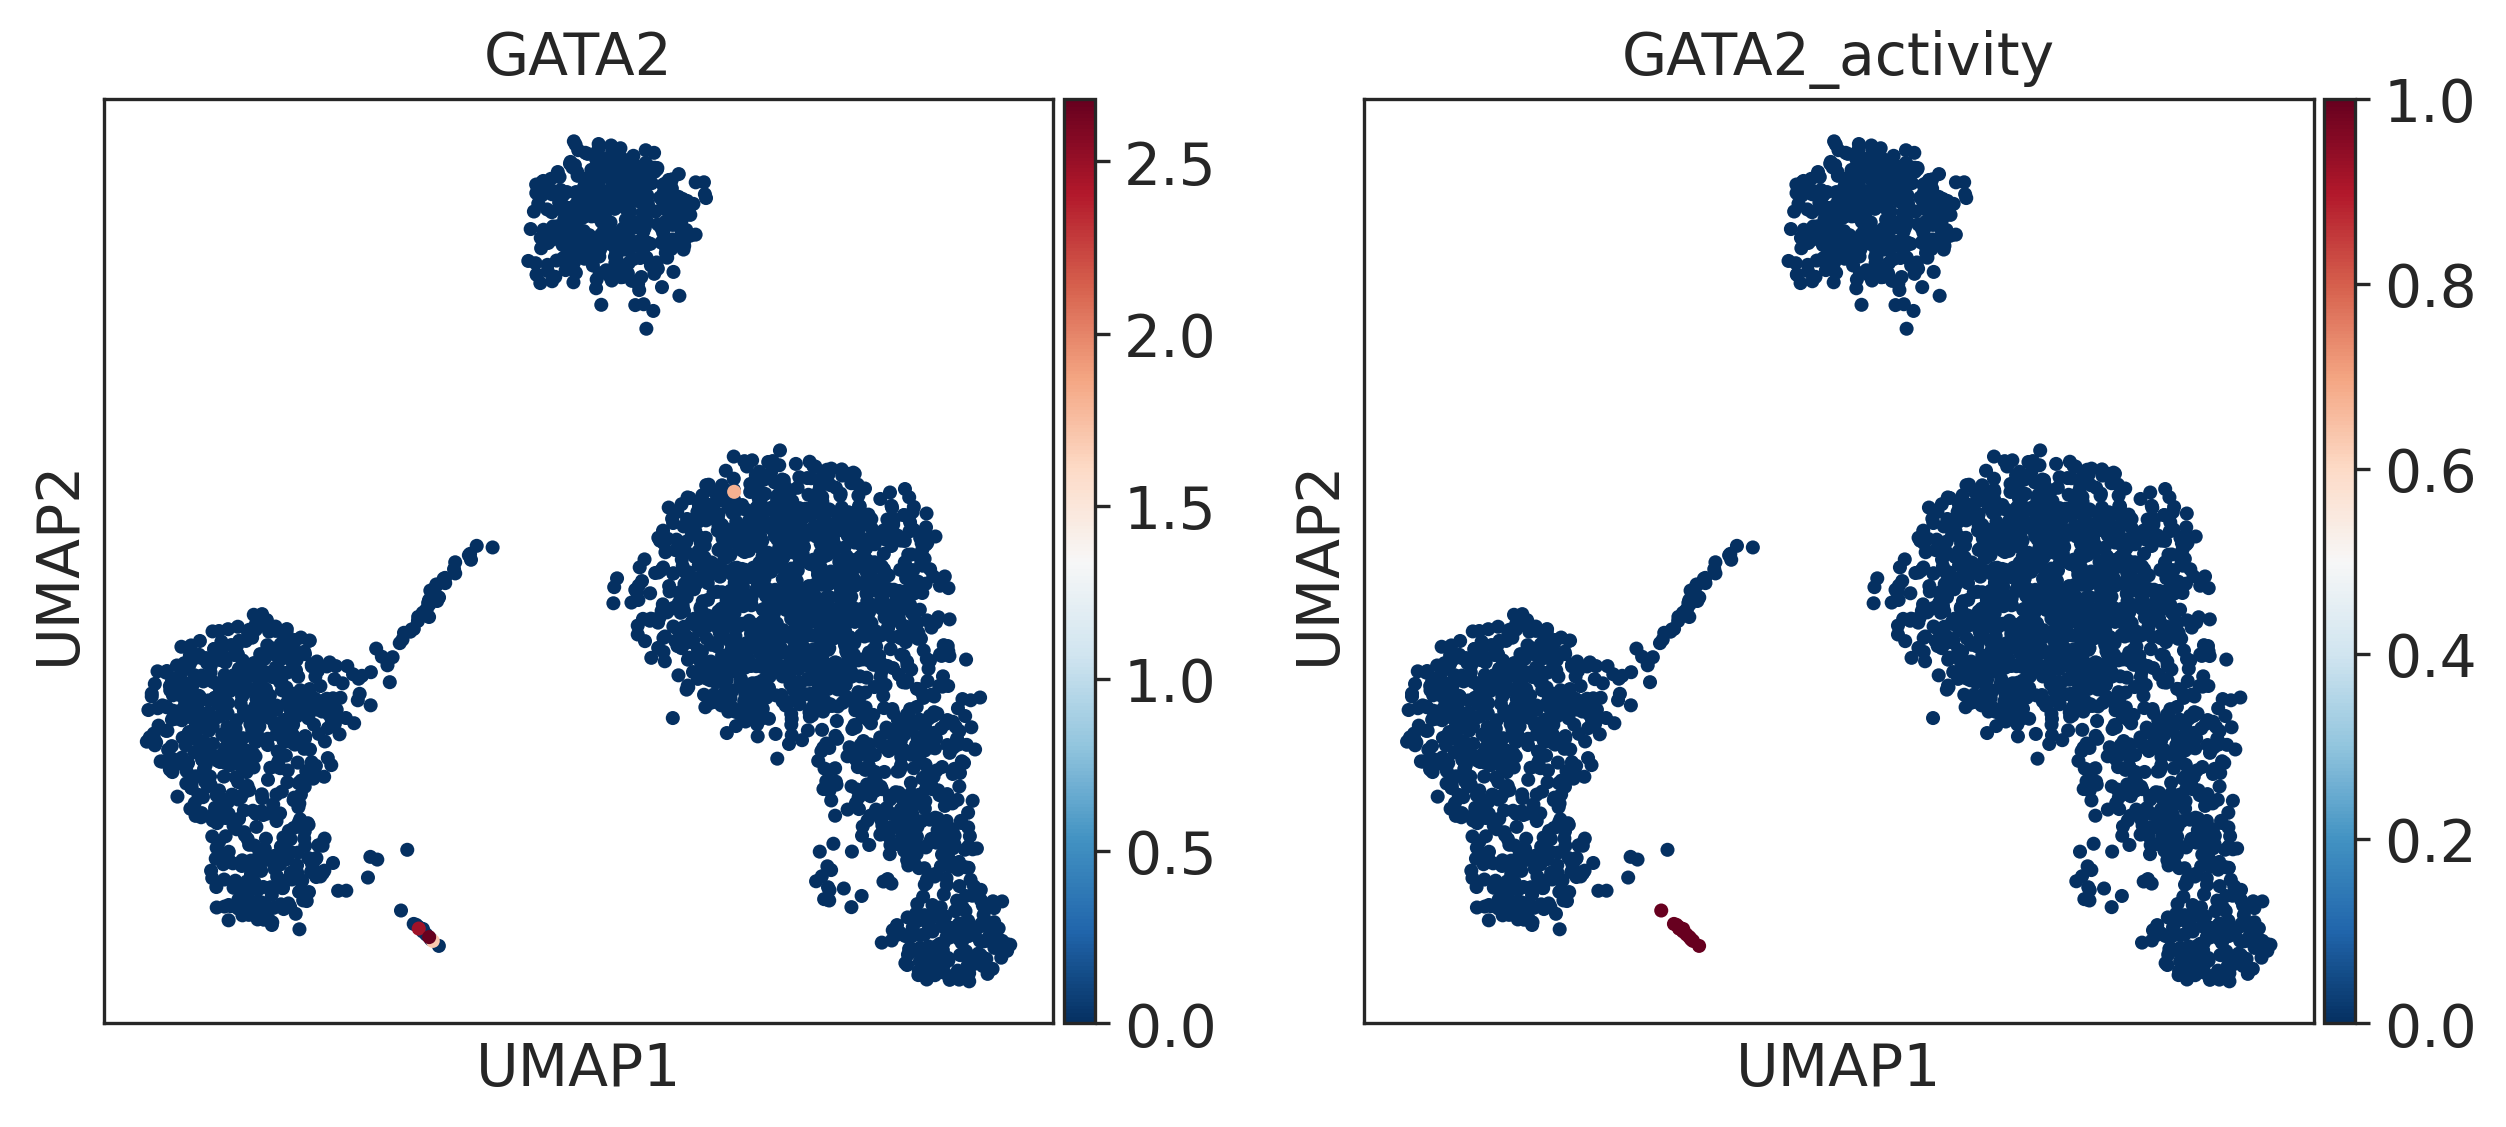

In [16]:
sc.pl.umap(adata, color=["GATA2", "GATA2_activity"], cmap="RdBu_r")

# Saving SCEPIA results

You can save and load the `AnnData` object as normal.

In [17]:
adata.uns['scepia']["cell_types"] = list(adata.uns['scepia']["cell_types"])

In [18]:
adata.write('PBMC3K.scepia.h5ad')

In [19]:
adata = sc.read('PBMC3K.scepia.h5ad')

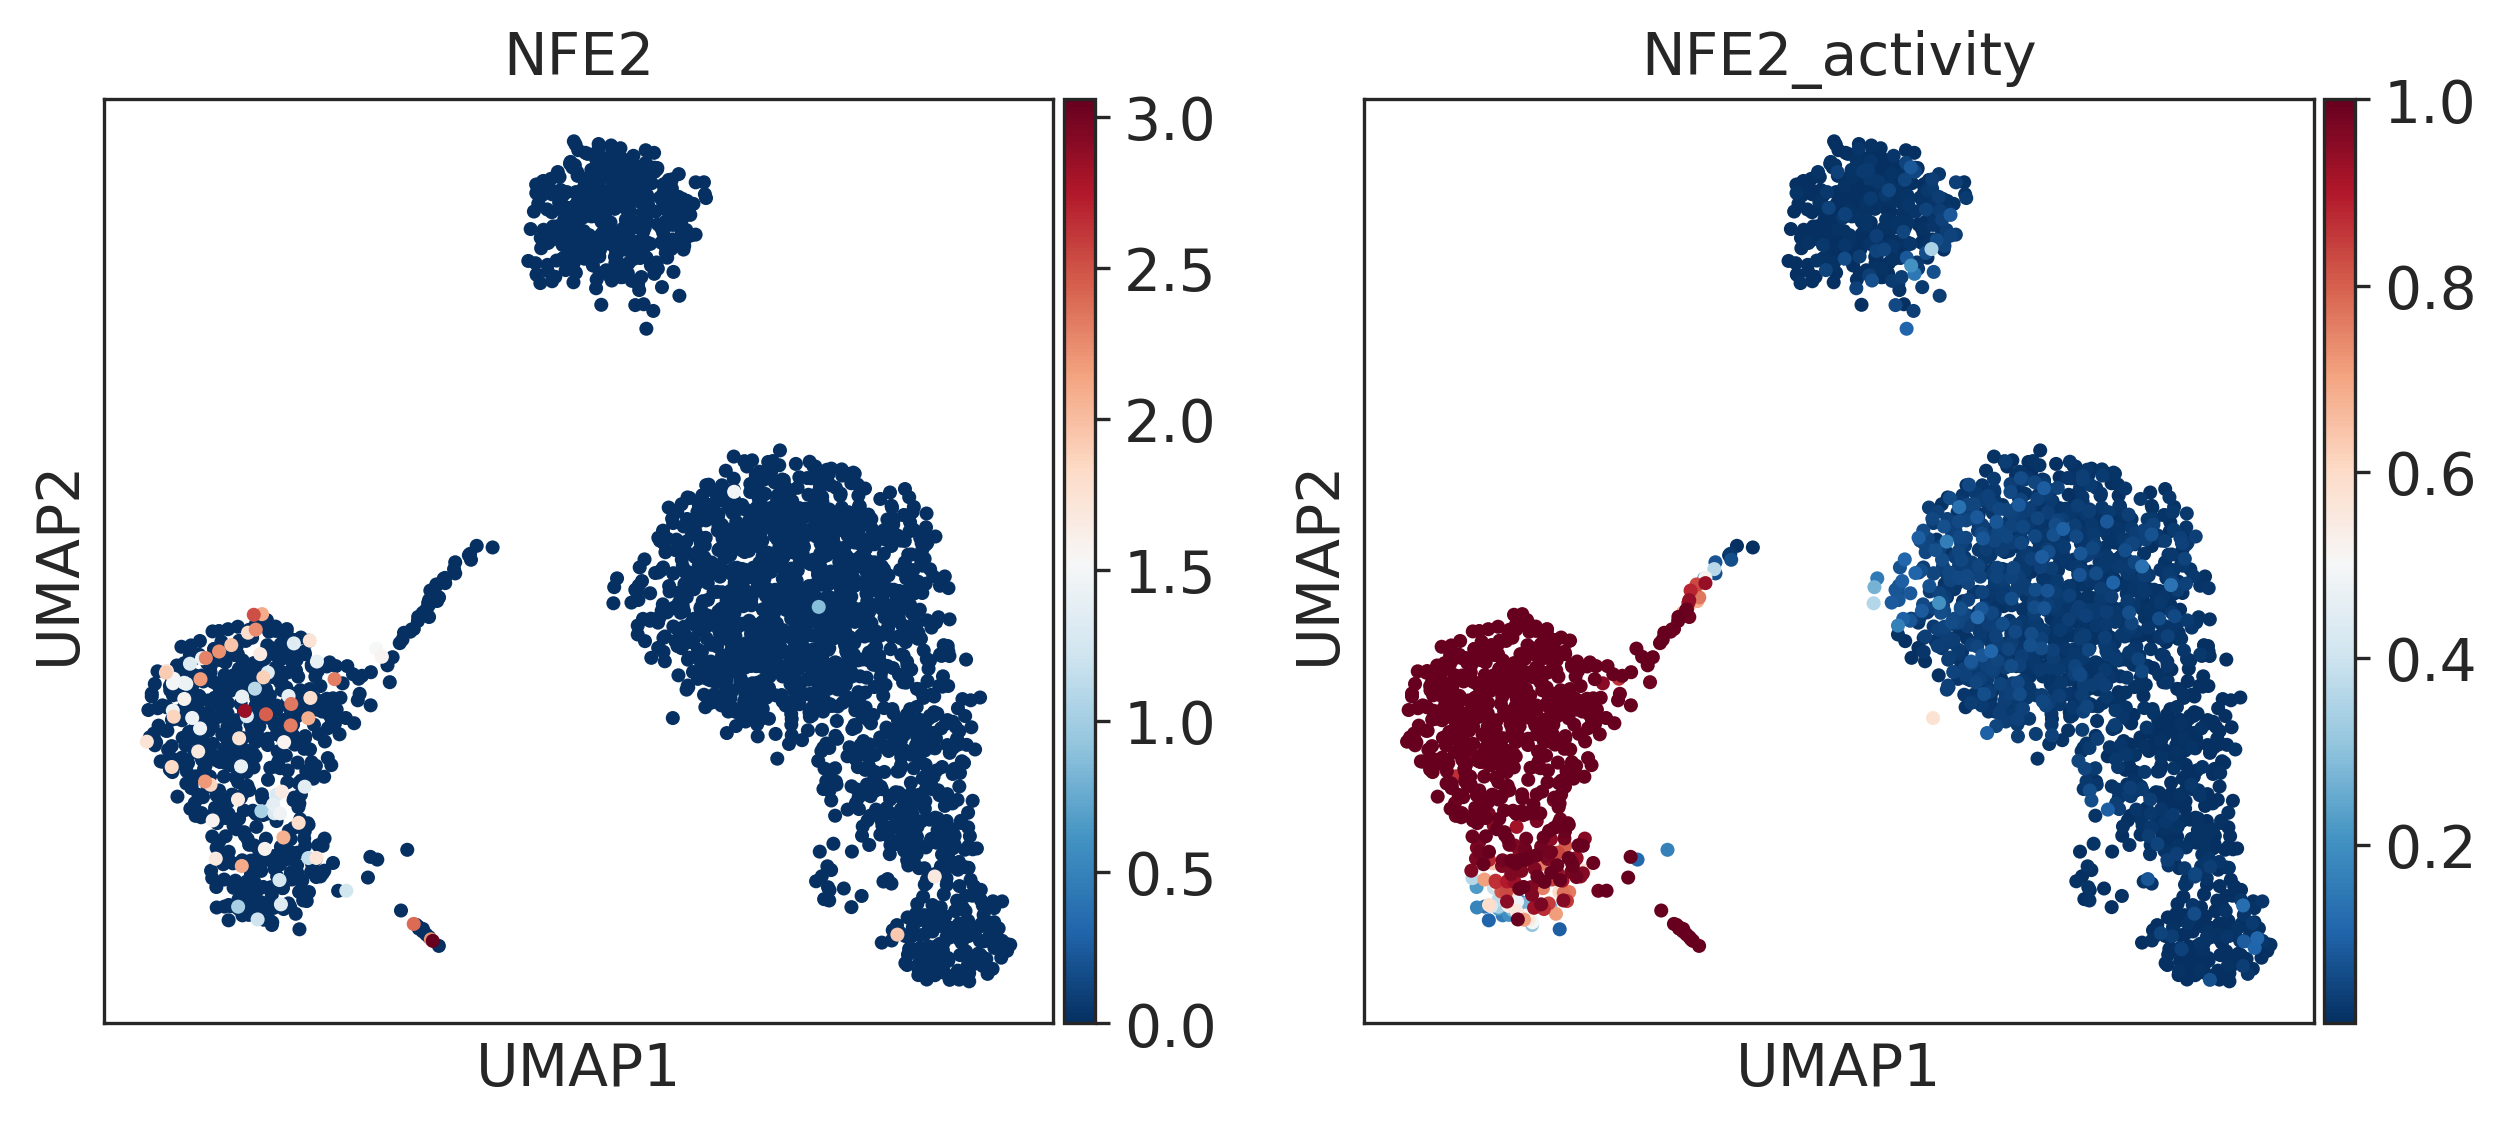

In [23]:
sc.pl.umap(adata, color=["NFE2", "NFE2_activity"], cmap="RdBu_r")